![alt text](https://o.aolcdn.com/images/dims?quality=100&image_uri=http%3A%2F%2Fo.aolcdn.com%2Fhss%2Fstorage%2Fmidas%2Fb0be09f425cc5175fb413bc03c32dd0d%2F206235889%2Fpubg-ed.jpg&client=amp-blogside-v2&signature=88c6b77342cbeb0d25c0dc9d909018136aec1971 "Logo Title Text 1")

### Loading Libraries

In [2]:
# For autoreloading modules
%load_ext autoreload
%autoreload 2
# For notebook plotting
%matplotlib inline

# Standard libraries
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pdpbox import pdp
from plotnine import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

# Machine Learning
import sklearn
from sklearn import metrics
from scipy.cluster import hierarchy as hc


In [3]:

# Directories
KAGGLE_DIR = '../input/'

# Load files

In [5]:
train = pd.read_csv(KAGGLE_DIR+'train_V2.csv')
test = pd.read_csv(KAGGLE_DIR+'test_V2.csv')

![API Img](http://media.comicbook.com/2018/03/pubg-api-1093349.jpeg)

In [6]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


### Feature descriptions (From Kaggle)

* DBNOs - Number of enemy players knocked.
* assists - Number of enemy players this player damaged that were killed by teammates.
* boosts - Number of boost items used.
* damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
* headshotKills - Number of enemy players killed with headshots.
* heals - Number of healing items used.
* Id - Player’s Id
* killPlace - Ranking in match of number of enemy players killed.
* killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
* killStreaks - Max number of enemy players killed in a short amount of time.
* kills - Number of enemy players killed.
* longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
* matchDuration - Duration of match in seconds.
* matchId - ID to identify match. There are no matches that are in both the training and testing set.
* matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
* rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
* revives - Number of times this player revived teammates.
* rideDistance - Total distance traveled in vehicles measured in meters.
* roadKills - Number of kills while in a vehicle.
* swimDistance - Total distance traveled by swimming measured in meters.
* teamKills - Number of times this player killed a teammate.
* vehicleDestroys - Number of vehicles destroyed.
* walkDistance - Total distance traveled on foot measured in meters.
* weaponsAcquired - Number of weapons picked up.
* winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
* groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* numGroups - Number of groups we have data for in the match.
* maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

[Source](https://www.kaggle.com/c/pubg-finish-placement-prediction/data)

# Illegal Matches

In [9]:
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,0,0,0,0.0,9,solo-fpp,1,1,1574,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [10]:
train.drop(2744604, inplace = True)

In [11]:
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc


# Feature Engineering

### Players Joined

Text(0.5,1,'playersJoined')

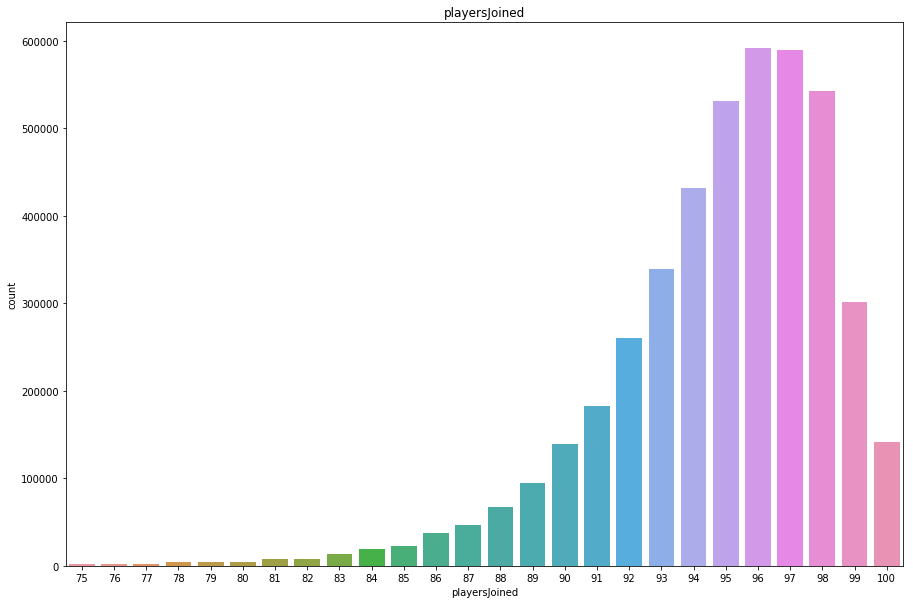

In [14]:
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')
plt.figure(figsize = (15,10))
sns.countplot(train[train['playersJoined']>=75]['playersJoined'])
plt.title('playersJoined')

### Normalisation

Now that we have a feature 'playersJoined' we can normalize other features based on the amount of players. Features that can be valuable to normalize are:
1. kills
2. damageDealt
3. maxPlace
4. matchDuration

In [16]:
train['killsNorm'] = train['kills'] * ((100 - train['playersJoined'])/100 + 1)
train['damageDealtNorm'] = train['damageDealt']*((100-train['playersJoined'])/100 + 1)
train['maxPlaceNorm'] = train['maxPlace']*((100-train['playersJoined'])/100 + 1)
train['matchDurationNorm'] = train['matchDuration']*((100-train['playersJoined'])/100 + 1)


to_show = ['Id', 'kills','killsNorm','damageDealt', 'damageDealtNorm', 'maxPlace', 'maxPlaceNorm', 'matchDuration', 'matchDurationNorm']
train[to_show][0:11]

,Id,kills,killsNorm,damageDealt,damageDealtNorm,maxPlace,maxPlaceNorm,matchDuration,matchDurationNorm
0,7f96b2f878858a,0,0.00,0.000,0.00000,28,29.12,1306,1358.24
1,eef90569b9d03c,0,0.00,91.470,99.70230,26,28.34,1777,1936.93
2,1eaf90ac73de72,0,0.00,68.000,69.36000,50,51.00,1318,1344.36
3,4616d365dd2853,0,0.00,32.900,35.86100,31,33.79,1436,1565.24
4,315c96c26c9aac,1,1.03,100.000,103.00000,97,99.91,1424,1466.72
5,ff79c12f326506,1,1.05,100.000,105.00000,28,29.40,1395,1464.75
6,95959be0e21ca3,0,0.00,0.000,0.00000,28,28.84,1316,1355.48
7,311b84c6ff4390,0,0.00,8.538,8.87952,96,99.84,1967,2045.68
8,1a68204ccf9891,0,0.00,51.600,53.14800,28,28.84,1375,1416.25
9,e5bb5a43587253,0,0.00,37.270,38.38810,29,29.87,1930,1987.90


# HACK: KILLS without Moving

![Alt Text](https://media.giphy.com/media/OPRbXcsGctvZC/giphy.gif)

In [21]:
# Create feature totalDistance
train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']
# Create feature killsWithoutMoving
train['killsWithoutMoving'] = ((train['kills'] > 0) & (train['totalDistance'] == 0))

In [22]:
display(train[train['killsWithoutMoving'] == True].shape)

(1535, 36)

In [23]:
train[train['killsWithoutMoving'] == True].head(10)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,totalDistance,killsWithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.00,0,0,3,18,0,6,3,23.540,593,normal-squad-fpp,15,13,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8571,58,8.52,842.0600,21.30,842.06,0.0,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.60,0,0,6,33,0,3,1,6.523,1794,normal-squad-fpp,11,11,1500,0,0.0,0,0.0,0,0,0.0,22,0,0.6000,42,4.74,547.6280,17.38,2834.52,0.0,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.00,0,4,5,3,0,20,6,37.080,898,normal-solo-fpp,20,15,1500,0,0.0,0,0.0,0,0,0.0,13,0,0.8947,21,35.80,3132.5000,35.80,1607.42,0.0,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.80,0,0,0,69,1000,1,1,21.540,799,normal-squad-fpp,19,18,-1,0,0.0,0,0.0,0,0,0.0,7,1500,0.0000,73,1.27,200.4060,24.13,1014.73,0.0,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.00,0,1,0,37,0,1,1,55.430,1794,normal-squad-fpp,11,11,1500,0,0.0,0,0.0,0,0,0.0,10,0,0.3000,42,1.58,158.0000,17.38,2834.52,0.0,True
20881,40871bf43ddac7,2cea046b7d1dce,0600f86f11c6e4,0,0,506.10,4,1,3,7,0,6,2,81.920,583,normal-squad,6,6,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8000,44,9.36,789.5160,9.36,909.48,0.0,True
23298,b950836d0427da,1f735b1e00d549,ad860f4e162bbc,1,0,1124.00,0,4,1,7,0,12,5,116.300,550,normal-squad-fpp,6,6,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.6000,48,18.24,1708.4800,9.12,836.00,0.0,True
24640,aeced11d46de19,d4009ffa95bb4f,73f3ed869c9171,2,0,529.90,0,2,11,12,0,7,2,84.370,599,normal-squad-fpp,15,15,1500,0,0.0,0,0.0,0,0,0.0,8,0,0.8571,57,10.01,757.7570,21.45,856.57,0.0,True
25659,6626c4d47cffa0,ee3fe5c0d917c3,341341834b7941,0,1,128.90,0,1,6,53,1000,2,1,26.990,732,normal-squad-fpp,8,8,-1,0,0.0,0,0.0,0,0,0.0,12,1500,0.2857,61,2.78,179.1710,11.12,1017.48,0.0,True
30079,869331b90bfa3f,869ea3ad036e53,fa373e28ff5062,0,0,85.56,0,0,0,46,0,1,1,16.440,715,normal-squad-fpp,15,14,1500,0,0.0,0,0.0,0,0,0.0,4,0,0.8571,53,1.47,125.7732,22.05,1051.05,0.0,True


In [24]:
train.drop(train[train['killsWithoutMoving'] == True].index, inplace = True)

### HACK: ROAD KILLS

![Alt Text](https://media.giphy.com/media/3o7aD85usFbbbrCR3i/giphy.gif)

In [25]:

# Players who got more than 10 roadKills
train[train['roadKills']>10]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,totalDistance,killsWithoutMoving
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,1403,14,13,7.181,1456,solo,92,80,-1,0,0.005,14,5.297,0,0,1277.0,0,1371,0.4286,92,15.12,1345.68,99.36,1572.48,1282.302,False
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,1497,11,11,0.000,1946,solo,88,77,-1,0,4118.000,11,0.000,0,0,816.6,5,1533,0.4713,88,12.32,1234.24,98.56,2179.52,4934.600,False
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,1114,20,18,64.290,1970,solo,38,20,-1,0,2726.000,18,0.000,0,0,3150.0,4,1568,1.0000,38,32.40,3359.88,61.56,3191.40,5876.000,False
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,1520,18,11,341.400,1925,solo,84,70,-1,0,6812.000,11,0.000,0,0,1041.0,10,1606,0.9398,84,20.88,2164.56,97.44,2233.00,7853.000,False


In [26]:
# Drop roadKill 'cheaters'
train.drop(train[train['roadKills'] > 10].index, inplace=True)

### HACK: KILLS

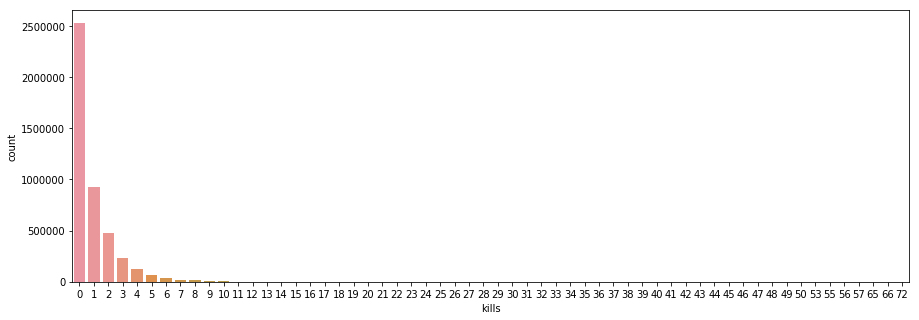

In [27]:
plt.figure(figsize = (15, 5))
sns.countplot(data = train, x = train['kills'])
plt.show()

In [28]:
train[train['kills']>30].shape

(95, 36)

In [29]:
train[train['kills']>30].head(10)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,totalDistance,killsWithoutMoving
57978,9d8253e21ccbbd,ef7135ed856cd8,37f05e2a01015f,9,0,3725.0,0,7,0,2,1000,35,3,105.80,1798,normal-duo-fpp,8,7,-1,0,0.0,0,0.0,0,0,48.82,48,1500,0.8571,16,64.40,6854.00,14.72,3308.32,48.82,False
87793,45f76442384931,b3627758941d34,37f05e2a01015f,8,0,3087.0,0,8,27,3,1000,31,3,95.34,1798,normal-duo-fpp,8,7,-1,0,0.0,0,0.0,0,0,780.70,45,1500,1.0000,16,57.04,5680.08,14.72,3308.32,780.70,False
156599,746aa7eabf7c86,5723e7d8250da3,f900de1ec39fa5,21,0,5479.0,0,12,7,4,0,48,6,81.95,1798,normal-solo-fpp,11,11,1500,0,0.0,0,0.0,0,0,23.71,61,0,0.7000,11,90.72,10355.31,20.79,3398.22,23.71,False
160254,15622257cb44e2,1a513eeecfe724,db413c7c48292c,1,0,4033.0,0,40,0,1,1000,42,5,266.20,844,normal-squad-fpp,8,8,-1,0,0.0,0,0.0,1,0,718.30,16,1500,1.0000,62,57.96,5565.54,11.04,1164.72,718.30,False
180189,1355613d43e2d0,f863cd38c61dbf,39c442628f5df5,5,0,3171.0,0,6,15,1,0,35,3,102.50,1796,normal-solo-fpp,9,6,1500,0,0.0,0,0.0,0,0,71.51,41,0,1.0000,11,66.15,5993.19,17.01,3394.44,71.51,False
334400,810f2379261545,7f3e493ee71534,f900de1ec39fa5,20,0,6616.0,0,13,5,1,0,65,7,73.90,1798,normal-solo-fpp,11,11,1500,0,0.0,0,0.0,0,0,1036.00,60,0,1.0000,11,122.85,12504.24,20.79,3398.22,1036.00,False
353128,f3e9746e3ff151,4bc1f00f07b304,a9e84c456cc859,2,0,3834.0,0,9,5,1,0,39,3,263.90,1795,normal-solo-fpp,13,10,1500,0,0.0,0,0.0,0,0,124.20,42,0,1.0000,13,72.93,7169.58,24.31,3356.65,124.20,False
457829,265e23756baa0b,9d94424171c2a1,664dee9ed8f646,3,0,2907.0,0,27,2,1,0,33,4,439.20,827,normal-squad,5,5,1500,0,0.0,0,0.0,1,0,382.40,15,0,1.0000,38,53.46,4709.34,8.10,1339.74,382.40,False
488335,31a0682922ef45,275a27a3ee4cc8,3037f74ef8a3a3,2,0,3055.0,0,9,0,1,1000,33,5,97.99,892,normal-solo-fpp,18,14,-1,0,0.0,0,0.0,0,0,35.30,31,1500,1.0000,20,59.40,5499.00,32.40,1605.60,35.30,False
662650,dd424a8b74bd49,ac9dea6d62f2e6,8a728def0644be,9,0,3454.0,38,9,4,1,1000,34,4,124.00,1198,normal-squad-fpp,14,14,-1,0,0.0,0,0.0,0,0,111.10,25,1500,0.2308,54,49.64,5042.84,20.44,1749.08,111.10,False


In [30]:
# Remove outliers
train.drop(train[train['kills'] > 30].index, inplace=True)

## HACK: HEAD-SHOT

![Alt Text](https://media.giphy.com/media/l3mZrOajz5VCZf7Hy/giphy.gif)

In [31]:
# create headshot_rate feature

train['headshot_rate'] = train['headshotKills'] / train['kills']
train['headshot_rate'] = train['headshot_rate'].fillna(0)

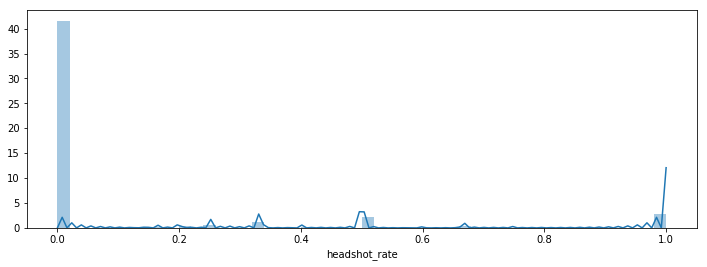

In [34]:
plt.figure(figsize = (12, 4))

sns.distplot(train['headshot_rate'])
plt.show()

In [35]:
# Players who made a minimum of 10 kills and have a headshot_rate of 100%
display(train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].shape)
train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].head(10)

(24, 37)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,totalDistance,killsWithoutMoving,headshot_rate
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,0,10,4,159.20,1423,squad-fpp,27,25,1564,1,0.0,0,0.0,0,0,2939.0,5,0,0.8462,93,10.70,1296.84,28.89,1522.61,2939.0,False,1.0
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,1424,11,2,633.60,1727,squad,27,26,-1,3,4720.0,0,0.0,0,0,3422.0,8,1560,1.0000,96,11.44,1684.80,28.08,1796.08,8142.0,False,1.0
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,1579,13,2,353.80,1255,squad,27,27,-1,0,0.0,0,0.0,0,0,2105.0,5,1587,1.0000,98,13.26,1392.30,27.54,1280.10,2105.0,False,1.0
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,1393,10,3,533.20,1838,squad-fpp,28,24,-1,0,5187.0,0,0.0,2,0,2761.0,7,1519,0.9630,95,10.50,1611.75,29.40,1929.90,7948.0,False,1.0
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,1543,10,2,277.00,1417,squad,27,26,-1,0,1018.0,0,0.0,0,0,2458.0,4,1562,1.0000,96,10.40,1409.20,28.08,1473.68,3476.0,False,1.0
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,0,11,3,484.90,1821,squad-fpp,28,27,1495,0,5246.0,0,0.0,0,0,2932.0,4,0,1.0000,95,11.55,1278.90,29.40,1912.05,8178.0,False,1.0
1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,1391,10,2,222.00,1246,squad-fpp,27,27,-1,0,408.9,0,0.0,0,0,2450.0,7,1468,1.0000,97,10.30,1096.95,27.81,1283.38,2858.9,False,1.0
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,0,12,2,443.00,1730,squad-fpp,28,28,1560,0,2048.0,0,0.0,0,0,3915.0,5,0,1.0000,93,12.84,1411.33,29.96,1851.10,5963.0,False,1.0
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,1000,11,3,289.60,1248,duo,46,41,0,1,0.0,0,0.0,0,0,3108.0,7,1500,1.0000,88,12.32,1288.00,51.52,1397.76,3108.0,False,1.0
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,0,13,3,95.14,1379,duo-fpp,49,48,1813,0,0.0,0,140.8,0,0,2339.0,4,0,1.0000,96,13.52,1537.12,50.96,1434.16,2479.8,False,1.0


In [36]:
# Remove outliers
train.drop(train[(train['headshot_rate'] == 1) & (train['kills'] > 9)].index, inplace=True)

### HACKER: LONGEST KILL

![Alt Text](https://media.giphy.com/media/RHJkLqcdvMQF4GI3P7/giphy.gif)

In [38]:
train[train['longestKill']>=1000].shape

(20, 37)

In [39]:
train[train['longestKill']>=1000].head(10)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,totalDistance,killsWithoutMoving,headshot_rate
202281,88e2af7d78af5a,34ddeede52c042,4346bc63bc67fa,0,3,783.9,5,1,1,5,0,4,3,1000.0,1864,squad,27,27,1482,0,723.2,0,0.0,0,1,3052.00,9,0,0.9231,88,4.48,877.968,30.24,2087.68,3775.20,False,0.250000
240005,41c2f5c0699807,9faecf87ab4275,634edab75860b3,5,0,1284.0,8,5,7,18,1000,11,2,1004.0,1308,normal-duo-fpp,14,13,-1,1,0.0,0,0.0,0,0,48.87,38,1500,0.5385,29,18.81,2195.640,23.94,2236.68,48.87,False,0.454545
324313,ef390c152bcc3d,30fd444be3bbc1,4f7f8d6cf558b4,2,0,1028.0,0,0,0,9,0,10,2,1026.0,698,normal-squad-fpp,13,13,1500,0,1717.0,0,0.0,0,0,1264.00,26,0,1.0000,51,14.90,1531.720,19.37,1040.02,2981.00,False,0.000000
656553,9948b058562163,c8cb8491112bf6,0104eeb664494d,6,0,1410.0,17,5,0,3,1000,16,4,1000.0,1091,normal-squad-fpp,6,6,-1,4,0.0,0,0.0,0,0,29.21,30,1500,0.6000,41,25.44,2241.900,9.54,1734.69,29.21,False,0.312500
803632,4e7e6c74e3c57d,94698690918933,da91b0c3d875f8,0,0,196.8,0,0,0,51,0,1,1,1075.0,471,normal-squad-fpp,8,8,1500,0,2085.0,0,0.0,0,0,1074.00,22,0,0.0000,61,1.39,273.552,11.12,654.69,3159.00,False,0.000000
895411,1f5ba6e0cfb968,512ea24b831be3,5fb0d8b1fc16cf,4,0,1012.0,11,5,0,5,0,10,3,1094.0,1021,normal-squad-fpp,12,12,1500,0,0.0,0,0.0,0,0,569.50,18,0,0.9091,86,11.40,1153.680,13.68,1163.94,569.50,False,0.500000
1172437,303a93cfa1f46c,8795d39fd0df86,9c8962b58bb3e3,2,1,329.3,0,0,2,45,1000,3,1,1037.0,581,normal-squad-fpp,8,7,-1,0,0.0,0,0.0,0,0,832.50,9,1500,0.2857,58,4.26,467.606,11.36,825.02,832.50,False,0.000000
1209416,528659ff1c1aec,7d1ba83423551d,ea9386587d5888,0,6,1640.0,0,7,0,1,1000,15,2,1001.0,1235,solo,52,51,-1,0,0.0,0,0.0,0,0,2848.00,4,1500,0.9412,52,22.20,2427.200,76.96,1827.80,2848.00,False,0.466667
1642712,91966848e08e2f,0ee4fbd27657c9,17dea22cefe62a,3,2,2103.0,0,4,11,11,0,23,2,1005.0,1798,normal-duo-fpp,15,12,1500,0,0.0,0,0.0,0,0,235.30,41,0,0.5000,28,39.56,3617.160,25.80,3092.56,235.30,False,0.173913
2015559,5ff0c1a9fab2ba,2d8119b1544f87,904cecf36217df,3,3,1302.0,0,6,5,15,0,11,2,1037.0,1794,normal-squad-fpp,11,11,1500,0,0.0,0,0.0,0,0,133.20,43,0,0.6000,42,17.38,2057.160,17.38,2834.52,133.20,False,0.545455


In [40]:
train.drop(train[train['longestKill']>=1000].index, inplace = True)

# HACK: withing distance

![Alt Text](https://media.giphy.com/media/qlCFjkSruesco/giphy.gif)

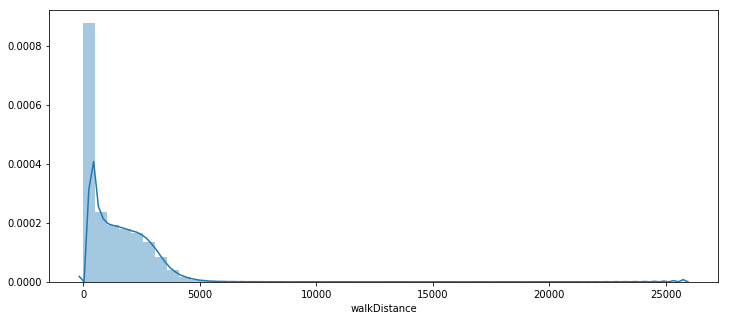

In [42]:
plt.figure(figsize = (12, 5))
sns.distplot(train['walkDistance'])


In [43]:
display(train[train['walkDistance'] >= 10000].shape)

(219, 37)

In [44]:
# Remove outliers
train.drop(train[train['walkDistance'] >= 10000].index, inplace=True)

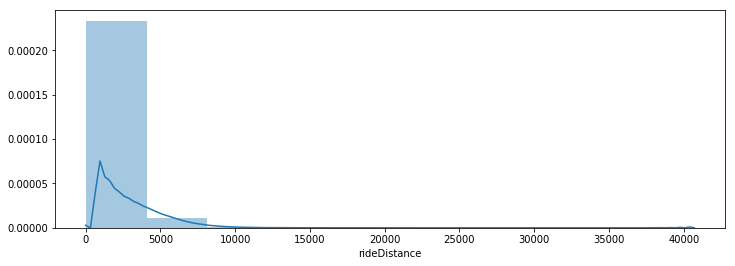

In [45]:
# Plot the distribution of rideDistance
plt.figure(figsize=(12,4))
sns.distplot(train['rideDistance'], bins=10)
plt.show()

In [46]:
# Remove outliers
train.drop(train[train['rideDistance'] >= 20000].index, inplace=True)

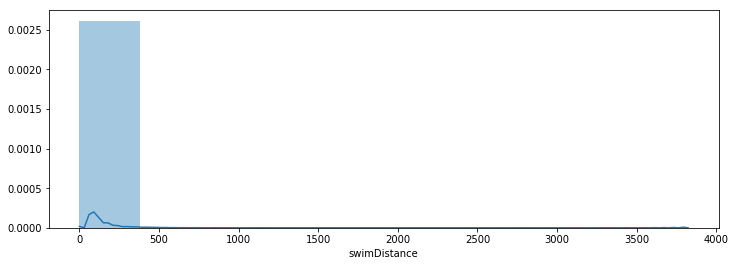

In [47]:
# Plot the distribution of swimDistance
plt.figure(figsize=(12,4))
sns.distplot(train['swimDistance'], bins=10)
plt.show()


![Alt Text](https://thumbs.gfycat.com/EvenSpiffyFerret-size_restricted.gif)

In [48]:
# Remove outliers
train.drop(train[train['swimDistance'] >= 2000].index, inplace=True)

# HACKER: weapons

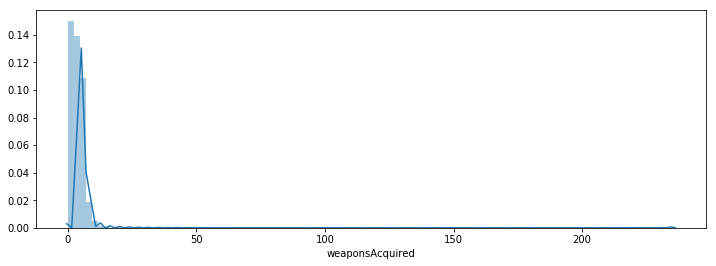

In [49]:
# Plot the distribution of weaponsAcquired
plt.figure(figsize=(12,4))
sns.distplot(train['weaponsAcquired'], bins=100)
plt.show()

In [50]:
train[train['weaponsAcquired']>=30].shape

(921, 37)

In [52]:
train.drop(train[train['weaponsAcquired']>=30].index, inplace = True)


![Alt Text](https://media.giphy.com/media/69lWR6c8Afx9qeg2Tu/giphy.gif)

# HACK: HEALS

# CATEGORICAL DATA

In [53]:
train['matchType'].unique()

array(['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
       'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
       'crashtpp', 'normal-solo'], dtype=object)

In [54]:
train['matchType'].nunique()

16

In [55]:
train = pd.get_dummies(train, columns = ['matchType'])

In [56]:
# Take a look at the encoding
matchType_encoding = train.filter(regex='matchType')
matchType_encoding.head()

,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [57]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,totalDistance,killsWithoutMoving,headshot_rate,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,96,0.00,0.0000,29.12,1358.24,244.8000,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,91,0.00,99.7023,28.34,1936.93,1445.0445,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755,98,0.00,69.3600,51.00,1344.36,161.8000,False,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667,91,0.00,35.8610,33.79,1565.24,202.7000,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875,97,1.03,103.0000,99.91,1466.72,49.7500,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [58]:
# Turn groupId and match Id into categorical types
train['groupId'] = train['groupId'].astype('category')
train['matchId'] = train['matchId'].astype('category')

In [59]:
# Get category coding for groupId and matchID
train['groupId_cat'] = train['groupId'].cat.codes
train['matchId_cat'] = train['matchId'].cat.codes

In [60]:
# Get rid of old columns
train.drop(columns=['groupId', 'matchId'], inplace=True)

In [61]:
# Lets take a look at our newly created features
train[['groupId_cat', 'matchId_cat']].head()

,groupId_cat,matchId_cat
0,613522,30083
1,827491,32748
2,843178,3143
3,1339918,45255
4,1757150,20530


In [62]:
train.head()

,Id,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,totalDistance,killsWithoutMoving,headshot_rate,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,groupId_cat,matchId_cat
0,7f96b2f878858a,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,96,0.00,0.0000,29.12,1358.24,244.8000,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,613522,30083
1,eef90569b9d03c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,91,0.00,99.7023,28.34,1936.93,1445.0445,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,827491,32748
2,1eaf90ac73de72,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755,98,0.00,69.3600,51.00,1344.36,161.8000,False,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,843178,3143
3,4616d365dd2853,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667,91,0.00,35.8610,33.79,1565.24,202.7000,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1339918,45255
4,315c96c26c9aac,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875,97,1.03,103.0000,99.91,1466.72,49.7500,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1757150,20530


In [63]:
train.drop(columns = ['Id'], inplace = True)

In [65]:
train.shape

(4443985, 51)

In [ ]:
train.head()